## Patient Survival Rate Prediction
this is sofi's comment

### Table of Contents

* [Introduction](#Introduction)
* [Data Description](#Data_Description)
* [Dataset](#Dataset)
* [LGBM (Light Gradient Boosting Machine)](#LGBM_Light_Gradient_Boosting_Machine)
* [Import Libraries](#Import_Libraries)
* [Import Dataset](#Import_Dataset)
* [Data Exploration](#Data_Exploration)
* [Encoding Methods](#Encoding_Methods)
<ul>
<li>OneHot Encoding</li>
<li>Label Encoding</li>
<li>Ordinal Encoding</li>
<li>Binary Encoding</li>
<li>Frequency Encoding</li>
<li>Mean Encoding</li>
</ul>
* [Handling Missing Data](#Handling_Missing_Data)
* [Implementing LGBM](#Implementing_LGBM)
* [AUC - ROC Curve](#AUC-ROC_Curve)

<a id='Introduction'></a>
### [Introduction](#Introduction)

The project examines patient health data collected from Argentina, Australia, New Zealand, Sri Lanka, Brazil, and more than 200 hospitals in the United States, as a result of worldwide collabration. The objective of the project is to create a model that composed of dataset from the first 24 hours of intensive care to predict patient survival. 

<a id='Data_Description'></a>
### [Data Description](#Data_Description)

The dataset is from MIT's GOSSIS community initiative. It consists of more than 130,000 hospital Intensive Care Unit (ICU) visits from patients over a one-year period.


<a id="Dataset"></a>
### [Dataset](#Dataset)

The training data consists of data with hospital_death provided. 

The testing data (unlabeled data) consists of data without hospital_death provided. 

<a id="Import_Libraries"></a>
### [Import Libraries](#Import_Libraries)

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import heapq
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
%matplotlib inline

import os


<a id="Import_Dataset"></a>
### [Import Dataset](#Import_Dataset)

In [46]:
dictionary = pd.read_csv('/Users/ty/Desktop/Projects/widsdatathon2020/OriginalData/WiDS_Datathon_2020_Dictionary.csv')
train = pd.read_csv('/Users/ty/Desktop/Projects/widsdatathon2020/OriginalData/training_v2.csv')
test = pd.read_csv('/Users/ty/Desktop/Projects/widsdatathon2020/OriginalData/unlabeled.csv')
#id = test.set_index('encounter_id')

<a id="Data_Exploration"></a>
### [Data Exploration](#Data_Exploration)

In [9]:
dictionary['Data Type'].unique()

array(['integer', 'binary', 'numeric', 'string'], dtype=object)

In [11]:
# Separate Numerical Data (Train Dataset)
num_variables_train = (train.select_dtypes(include='number')).columns
# Separete Catagorical Data 
cat_train = [col for col in train.columns if train.dtypes[col] == 'object']

In [12]:
# List of Numerical Variables in Train Dataset
num_variables_train

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days',
       ...
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 'aids',
       'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis'],
      dtype='object', length=178)

In [163]:
# Total Number of Numerical Variables in Train Dataset
len(num_variables_train)

178

In [164]:
# Separate Numerical Data (Test) 
num_variables_test = (test.select_dtypes(include='number')).columns
# Separate Catagorical Data (Test) 
cat_test = [col for col in test.columns if test.dtypes[col] == 'object']

In [165]:
# List of Catagorical Variables (Method 1)
cat_train

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [16]:
# List Categorical Variables (Method 2)
# print([c for c in train.columns if (1< train[c].nunique()) & (train[c].dtype != np.number)& (train[c].dtype != int) ])

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


In [17]:
categorical_cols =  ['hospital_id','ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem',"hospital_death"]

In [191]:
categorical_train= train[categorical_cols]
# categorical_train.head(5)

<a name="Encoding_Methods"></a>
### [Encoding Methods](#Encoding_Methods)

#### OneHot Encoding    
One-hot encoding is one of the most popular encoding technique. It creates a column for each category in the feature and assigning a 0 or 1 to label each category.

In [19]:
X = pd.DataFrame(categorical_train['ethnicity'])
categorical_train['ethnicity'].value_counts()

Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64

In [20]:
one_hot_encoding = pd.get_dummies(X)
one_hot_encoding.head()

,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


#### Label Encoding 
Label encoding technique transforms non-numerical labels into numerical labels. Each category is assigned a number starting from 0 and continue until n. 

In [21]:
le = LabelEncoder()  
gender = pd.DataFrame(le.fit_transform(categorical_train['gender'].astype('str')))
gender.columns = ['Gender']
gender.head()

,Gender
0,1
1,0
2,0
3,0
4,1


#### Ordinal Encoding
Ordinal encoding uses a single column of integers to identify the classes. 

In [22]:
icu_st = pd.DataFrame(categorical_train['icu_stay_type'])
icu_st.columns = ['icu_stay_type']
icu_st_dict={'admit':0,'readmit':1,'transfer':2}
icu_st['icu_st_ordinal'] = icu_st.icu_stay_type.map(icu_st_dict)
icu_st.head(5)

,icu_stay_type,icu_st_ordinal
0,admit,0
1,admit,0
2,admit,0
3,admit,0
4,admit,0


#### Binary Encoding 

Binary encoding transforms a category into a binary number for an individual feature column. In the case of n categories of features, binary encoding results in log(base 2)ⁿ. 

In [23]:
categorical_train['apache_3j_bodysystem'].unique()

array(['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma',
       'Neurological', 'Gastrointestinal', 'Genitourinary', nan,
       'Hematological', 'Musculoskeletal/Skin', 'Gynecological'],
      dtype=object)

In [192]:
apache_3 = pd.DataFrame(categorical_train['apache_3j_bodysystem'])
apache_3 = apache_3.dropna()
apache_3.columns =['apache_3j_bodysystem']
encoder = ce.BinaryEncoder(cols = ['apache_3j_bodysystem'])
apache_bin = encoder.fit_transform(apache_3['apache_3j_bodysystem'])
apache_3 = pd.concat([apache_3,apache_bin],axis = 1)
apache_3.head(5)

,apache_3j_bodysystem,apache_3j_bodysystem_0,apache_3j_bodysystem_1,apache_3j_bodysystem_2,apache_3j_bodysystem_3,apache_3j_bodysystem_4
0,Sepsis,0,1,0,1,0
1,Respiratory,0,1,0,0,1
2,Metabolic,0,0,1,1,0
3,Cardiovascular,0,0,0,0,1
4,Trauma,0,1,0,1,1


#### Frequency Encoding 
Frequency encoding is corresponding with the target variable.

In [25]:
categorical_train['hospital_admit_source'].unique()

array(['Floor', 'Emergency Department', 'Operating Room', nan,
       'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU',
       'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)',
       'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other'],
      dtype=object)

In [56]:
hosp_asource = pd.DataFrame(categorical_train['hospital_admit_source'])
hosp_asource = hosp_asource.dropna()
hosp_asource.columns =['hospital_admit_source']
fe = hosp_asource.groupby('hospital_admit_source').size()/len(hosp_asource)
hosp_asource.loc[:,'hospital_admit_source_fe'] = hosp_asource['hospital_admit_source'].map(fe)
hosp_asource.head()

,hospital_admit_source,hospital_admit_source_fe
0,Floor,0.114574
1,Floor,0.114574
2,Emergency Department,0.525745
3,Operating Room,0.139210
5,Direct Admit,0.091616


#### Mean Encoding 

Mean encoding has similarities to label encoding, the difference is that Mean Encoding corresponding to the target. For example, in mean target encoding for each category in the feature label is determined by the mean value of the target variable of the training data.

In [58]:
categorical_train['icu_type'].unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

In [61]:
icu_type = pd.DataFrame(categorical_train[['icu_type','hospital_death']])
icu_type = icu_type.dropna()
icu_type.columns =['icu_type','hospital_death']
mean_encode = icu_type.groupby('icu_type')['hospital_death'].mean()
icu_type.loc[:,'icu_type_mean_en'] = icu_type['icu_type'].map(mean_encode)
icu_type.head()

,icu_type,hospital_death,icu_type_mean_en
0,CTICU,0,0.060205
1,Med-Surg ICU,0,0.087495
2,Med-Surg ICU,0,0.087495
3,CTICU,0,0.060205
4,Med-Surg ICU,0,0.087495


In [62]:
# Separate Integer, Binary, Numeric and String Data

features_integer = dictionary[dictionary['Data Type'] == 'integer']['Variable Name'].values
features_binary = dictionary[dictionary['Data Type'] == 'binary']['Variable Name'].values
features_numeric =dictionary[dictionary['Data Type'] == 'numeric']['Variable Name'].values
features_string = dictionary[dictionary['Data Type'] == 'string']['Variable Name'].values

#### Death Rate vs Gender

In [68]:
train[['hospital_death', 'gender']].groupby(['gender'])[['hospital_death']].mean()

,hospital_death
gender,
F,0.088373
M,0.084417


#### Death Rate vs Age

In [193]:
age_death=train[['hospital_death', 'age']].groupby(['age'])[['hospital_death']].mean()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# print(age_death)

In [133]:
# Age is a column, NOT an index:
age_death=train[['hospital_death', 'age']].groupby(['age'])[['hospital_death']].mean()
# age_death

In [136]:
# Age is index now:
age_death2=train[['hospital_death', 'age']].groupby(['age'])[['hospital_death']].mean().reset_index()
# age_death2
# age_death2.columns

Index(['age', 'hospital_death'], dtype='object')

In [137]:
# age is index now:
a = train[['hospital_death', 'age']].groupby(['age'])[['hospital_death']].mean()
# a.index

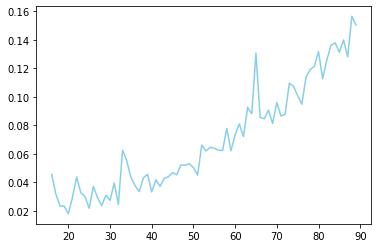

In [138]:
plt.plot( 'age', 'hospital_death', data=age_death2, color='skyblue')
plt.show()


#### Death Rate vs Ethnicity

In [76]:
ethnicity1=train[['hospital_death', 'ethnicity']].groupby(['ethnicity'])[['hospital_death']].mean()

In [77]:
ethnicity2=train[['hospital_death', 'ethnicity']].groupby(['ethnicity'])[['hospital_death']].mean().reset_index()

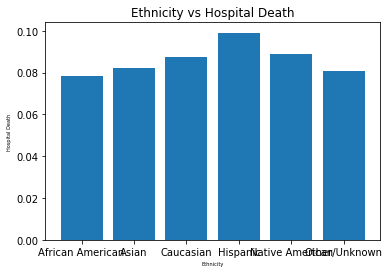

In [78]:
plt.bar('ethnicity','hospital_death',  data = ethnicity2)
plt.xlabel('Ethnicity', fontsize=5)
plt.ylabel('Hospital Death', fontsize=5)
plt.title('Ethnicity vs Hospital Death')
plt.show()

In [79]:
ethnicity1.index

Index(['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other/Unknown'], dtype='object', name='ethnicity')

In [80]:
ethnicity1.index.values

array(['African American', 'Asian', 'Caucasian', 'Hispanic',
       'Native American', 'Other/Unknown'], dtype=object)

In [81]:
type(train['gender'])

pandas.core.series.Series

In [85]:
mean_death=train['hospital_death'].mean()
round(mean_death, 3)

0.086

<a id="Handling_Missing_Data"></a>
### [Handling Missing Data](Handling_Missing_Data)

In [ ]:
count_non_na = train.count().sort_values()

In [ ]:
# Top 20 Most Populated Columns
# pd.DataFrame(count_non_na)[-20:]

In [195]:
# Top 5 Most Populated Columns 
pd.DataFrame(count_non_na)[-5:]

,0
icu_type,91713
pre_icu_los_days,91713
readmission_status,91713
patient_id,91713
encounter_id,91713


In [196]:
# Bottom 5 Least Populated columns
pd.DataFrame(count_non_na)[:5]

,0
h1_bilirubin_min,7094
h1_bilirubin_max,7094
h1_lactate_min,7344
h1_lactate_max,7344
h1_albumin_min,7889


In [91]:
fill_train = train[['gender','ethnicity']]
fill_train.isna().sum()

gender         25
ethnicity    1395
dtype: int64

In [139]:
fill_train['gender'].fillna(method='bfill',inplace = True)

fill_train['ethnicity'].fillna(method='ffill',inplace = True)
# fill_train.isna().sum()

In [93]:
imputer_skdf = train[['readmission_status','weight']]

In [94]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer_skdf = pd.DataFrame(imputer.fit_transform(imputer_skdf))
imputer_skdf.columns = ['readmission_status','weight']

imputer_skdf.isna().sum()

readmission_status    0
weight                0
dtype: int64

In [95]:
categ_train = train[['ethnicity','gender']]
print("ICU Stay Type - value Counts : \n " ,categ_train['ethnicity'].value_counts())
print("ICU Type - value Counts : \n " , categ_train['gender'].value_counts())

ICU Stay Type - value Counts : 
  Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64
ICU Type - value Counts : 
  M    49469
F    42219
Name: gender, dtype: int64


In [98]:
categ_train.isna().sum()

ethnicity    1395
gender         25
dtype: int64

In [144]:
cols_train = (train.select_dtypes(include='object')).columns
for col in cols_train:
    train[col] = train[col].astype('category')

In [145]:
cols_test = (test.select_dtypes(include='object')).columns
for col in cols_test:
    test[col] = test[col].astype('category')

In [146]:
#for each non-numeric column convert its data type to categorical (Train)

for col in cols_train:
    train[col] = pd.categorical(train[col])
    train[col] = train[col].cat.codes
    train[col] = pd.categorical(train[col])

# Generate a logical index of categorical columns to  use with LightGBM later
cat_cols_train = [i for i,v in enumerate(train.dtypes) if str(v)=='category']

In [147]:
#for each non-numeric column convert its data type to categorical (Test)

for col in cols_test:
    test[col] = pd.categorical(test[col])
    test[col] = test[col].cat.codes
    test[col] = pd.categorical(test[col])

    # Generate a logical index of categorical columns to  use with LightGBM later
cat_cols_test = [i for i,v in enumerate(test.dtypes) if str(v)=='category']

In [170]:
# Replace NAs with Median for Numerical Variables (train)

for variable in num_variables_train:
    median = train[variable].median()
    train[variable].fillna(median, inplace=True)

In [171]:
# Replace NAs with Median for Numerical Variables (test)

for variable in num_variables_test:
    median = test[variable].median()
    test[variable].fillna(median, inplace=True)

In [172]:
# For the training data, create dataframe of count of non-missing values for each variable.
non_missing_values_train = pd.DataFrame(train.count())

# Rename column.
non_missing_values_train.rename(columns={0:"count"}, inplace=True)

# Add new column that calculates the percent of total rows that are populated by non-missing values.
total = train.shape[0]
non_missing_values_train['pct_complete'] = non_missing_values_train / total

In [174]:
# For the trianing data, drop columns that have 30% or more non-missing values
non_missing_values_train[non_missing_values_train['pct_complete']<.7].shape[0]
non_missing_values_train[non_missing_values_train['pct_complete']>=.7].shape[0]

non_missing_values_train[non_missing_values_train['pct_complete']<.7].join(dictionary).sort_values('pct_complete',ascending=False)
drop = non_missing_values_train[non_missing_values_train['pct_complete']<.7].index.values

train = train.drop(drop, axis=1)

In [175]:
# For the testing data, create dataframe of count of non-missing values for each variable.
non_missing_values_test = pd.DataFrame(test.count())

# Rename column.
non_missing_values_test.rename(columns={0:"count"}, inplace=True)

# Add new column that calculates the percent of total rows that are populated by non-missing values.
total = test.shape[0]
non_missing_values_test['pct_complete'] = non_missing_values_test / total

In [176]:
# For the testing data, drop columns that have 30% or more non-missing
non_missing_values_test[non_missing_values_test['pct_complete']<.7].shape[0]
non_missing_values_test[non_missing_values_test['pct_complete']>=.7].shape[0]

non_missing_values_test[non_missing_values_train['pct_complete']<.7].join(dictionary).sort_values('pct_complete',ascending=False)
drop = non_missing_values_test[non_missing_values_test['pct_complete']<.7].index.values

test = test.drop(drop, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [177]:
# Replace NAs with Mode for Categorical Variables (Train)

for variable in cat_train:
    mode = train[variable].mode()[0]
    train[variable].fillna(mode, inplace=True)

In [178]:
# Replace NAs with Mode for Categorical Variables (Test)

for variable in cat_test:
    mode = train[variable].mode()[0]
    train[variable].fillna(mode, inplace=True)

<a id="LGBM_(Light_Gradient_Boosting_Machine)"></a>
### [LGBM (Light Gradient Boosting Machine)](#LGBM_Light_Gradient_Boosting_Machine)

LGBM is a gradient boosting framework which uses decision tree algorithm. It is widely applied as a classification technique. 

LGBM uses the leaf-wise tree growth algorithm whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy.

Leaf-wise splits may cause overfitting, however the overfiting problem can be solved by specifying an additional parameter max-depth which specifies the depth when splitting occurs.

<a id="Implementing_LGBM"></a>
### [Implementing LGBM](Implementing_LGBM)

In [179]:
# Identify Target Variable
y = train['hospital_death'] 

# Identify Predictor Variable
x = train.drop('hospital_death', axis=1)

In [180]:
# Split training data into train(0.7) and test(0.3)

from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

In [181]:
train_data = lightgbm.Dataset(train_x, label=train_y)
test_data = lightgbm.Dataset(val_x, label=val_y)

In [ ]:
# grid = {'depth': [7, 11],
#         'application': 'binary',
#         'objective': 'binary',
#         'metric': 'auc',
#         'lambda_l1': 1,
#         'lambda_l2': 1,
#         'is_unbalance': 'true',
#         'boosting': 'gbdt',
#         'num_leaves': 31,
#         'feature_fraction': 0.9,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 10,
#         'learning_rate': 0.04,
#         'scale_pos_weight':1,
#         'verbose': 0
# }


# model = lightgbm.train(grid,
#                        train_data,
#                        valid_sets=test_data,
#                        num_boost_round=5000,
#                        early_stopping_rounds=500)

In [ ]:
# Result:
# Early stopping, best iteration is:
# [321]	valid_0's auc: 0.90163

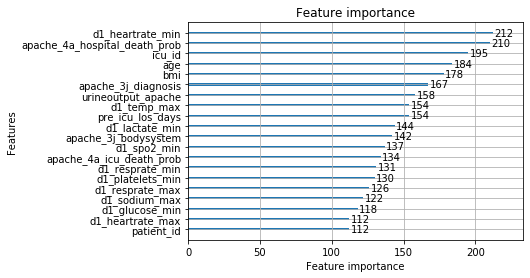

In [183]:
ax = lightgbm.plot_importance(model, max_num_features=20)
plt.show()

In [178]:
# Import libraries
# roc curve and auc score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

<a id="AUC-ROC_Curve"></a>
### [AUC - ROC Curve](AUC-ROC_Curve)

AUC - ROC curve is a performance measurement for classification purposes at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. AUC - ROC curve determines the model efficiency of differiate different classes.

The higher the AUC value, the better efficiency of the model i.e. better prediction on patients associate with hospital death. 
 
The ROC curve is depict with TPR (True Positive Rate) against the FPR (False Positve Rate), where TPR is on y-axis and FPR is on the x-axis.

In [179]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

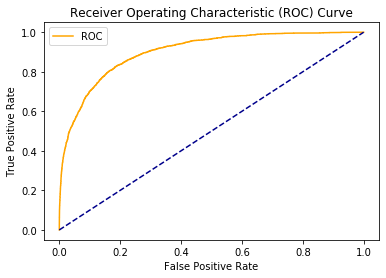

AUC-ROC : 0.9016260831880011


In [180]:
probs = model.predict(val_x)
# probs = probs[:, 1]
auc = roc_auc_score(val_y, probs)
fpr, tpr, thresholds = roc_curve(val_y, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)